# 🧠 **Brain Tumor Segmentation with Deep Learning**

This project focuses on *automatic brain tumor segmentation from MRI scans, leveraging the power of **deep learning and computer vision. Brain tumors are among the most life-threatening diseases, and accurate segmentation plays a crucial role in **diagnosis, treatment planning, and monitoring disease progression. Manual annotation by radiologists is time-consuming and subject to human error, which highlights the importance of **AI-driven solutions** in healthcare.  

The developed pipeline combines *modern preprocessing techniques, **robust data augmentation strategies, and a **UNet-based segmentation model** to accurately detect and delineate tumor regions at the pixel level. The system was trained and validated on a public dataset of brain MRI scans, with masks provided for supervised learning.  

---
# **Key Highlights of the Project:**
- 📊 **Exploratory Data Analysis (EDA):** Visual insights into the dataset, class distribution, mask coverage, and image quality to better understand challenges in medical imaging.  
- 🛠 **Preprocessing & Augmentation:** Images were normalized, resized, and augmented with transformations (flips, rotations, brightness/contrast shifts) to improve model generalization.  
- 🧩 **Deep Learning Architecture:** UNet with a *ResNet34 encoder pretrained on ImageNet*, ensuring strong feature extraction capabilities while maintaining efficiency.  
- ⚖ **Custom Hybrid Loss Function:** A balanced combination of *Binary Cross Entropy (BCE)* and *Dice Loss* to optimize pixel-wise classification and overall segmentation overlap.  
- 📈 **Evaluation Metrics:** IoU (Intersection over Union) and Dice coefficient were used for rigorous performance monitoring, ensuring robustness and accuracy.  
- 🎨 **Visualization Tools:** Overlay masks and predictions on original MRI scans for intuitive evaluation of model predictions.  

---
# *Why This Project Matters:*
This work demonstrates how *AI and medical imaging* can come together to provide *decision support systems* for healthcare professionals. The resulting model can help reduce radiologist workload, improve diagnostic speed, and ensure early detection of brain tumors — ultimately contributing to *better patient outcomes*.  

---
🚀 This project represents a step forward toward *AI-powered healthcare solutions*, bridging the gap between **research and real-world clinical applications**.

# **Install required libraries**


In [1]:
!pip install -q --upgrade pip
!pip install -q segmentation-models-pytorch==0.3.1
!pip install -q timm==0.4.12
!pip install -q albumentations==1.3.0
!pip install -q torchmetrics==0.11.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'efficientnet-pytorch' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'efficientnet-pytorch'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'pretrainedmodels' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.t

# **Imports & setup**


In [2]:
import os, random, math, glob
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import torchmetrics

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

2025-09-29 11:14:08.998894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759144449.181232      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759144449.237263      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device: cuda


# **Paths & quick inspect**


In [3]:
DATA_ROOT = Path("/kaggle/input/brain-tumor-segmentation")  
images_dir = DATA_ROOT / "images"
masks_dir  = DATA_ROOT / "masks"

print("Images exists:", images_dir.exists())
print("Masks exists: ", masks_dir.exists())

sample_images = list(images_dir.glob("*"))[:6]
print("Sample images count:", len(sample_images))

Images exists: True
Masks exists:  True
Sample images count: 6


#  **Dataset class & transforms**


In [4]:
class BrainTumorSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transforms=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))
        mask = (mask > 127).astype("float32")  
        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  
        else:
            img = TF.to_tensor(img)
            mask = torch.tensor(mask).unsqueeze(0)
        return img, mask

train_transform = A.Compose([
    A.Resize(256,256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(256,256),
    A.Normalize(),
    ToTensorV2()
])

#  **Prepare train/val & dataloaders**


In [5]:
all_images = sorted(list(images_dir.glob("*")))
all_masks  = [masks_dir / img.name for img in all_images]

from sklearn.model_selection import train_test_split
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    all_images, all_masks, test_size=0.15, random_state=SEED
)

train_ds = BrainTumorSegDataset(train_imgs, train_masks, transforms=train_transform)
val_ds   = BrainTumorSegDataset(val_imgs, val_masks, transforms=valid_transform)

BATCH_SIZE = 8
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))

Train batches: 326 Val batches: 58


# **Exploratory Data Analysis**

#  Dataset statistics


Total images: 3064
Train: 2604 | Val: 460


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


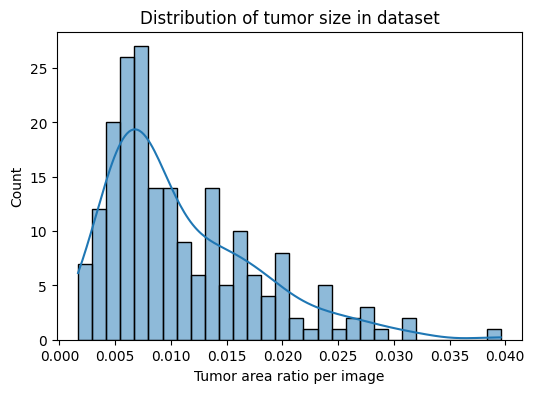

Mean tumor coverage: 1.10%


In [6]:
import cv2
import seaborn as sns

print(f"Total images: {len(all_images)}")
print(f"Train: {len(train_imgs)} | Val: {len(val_imgs)}")

tumor_pixels = []
for m in all_masks[:200]:  
    mask = np.array(Image.open(m).convert("L"))
    mask_bin = (mask > 127).astype(np.uint8)
    ratio = mask_bin.sum() / mask_bin.size
    tumor_pixels.append(ratio)

plt.figure(figsize=(6,4))
sns.histplot(tumor_pixels, bins=30, kde=True)
plt.xlabel("Tumor area ratio per image")
plt.ylabel("Count")
plt.title("Distribution of tumor size in dataset")
plt.show()

print(f"Mean tumor coverage: {np.mean(tumor_pixels)*100:.2f}%")

# Visualize random samples


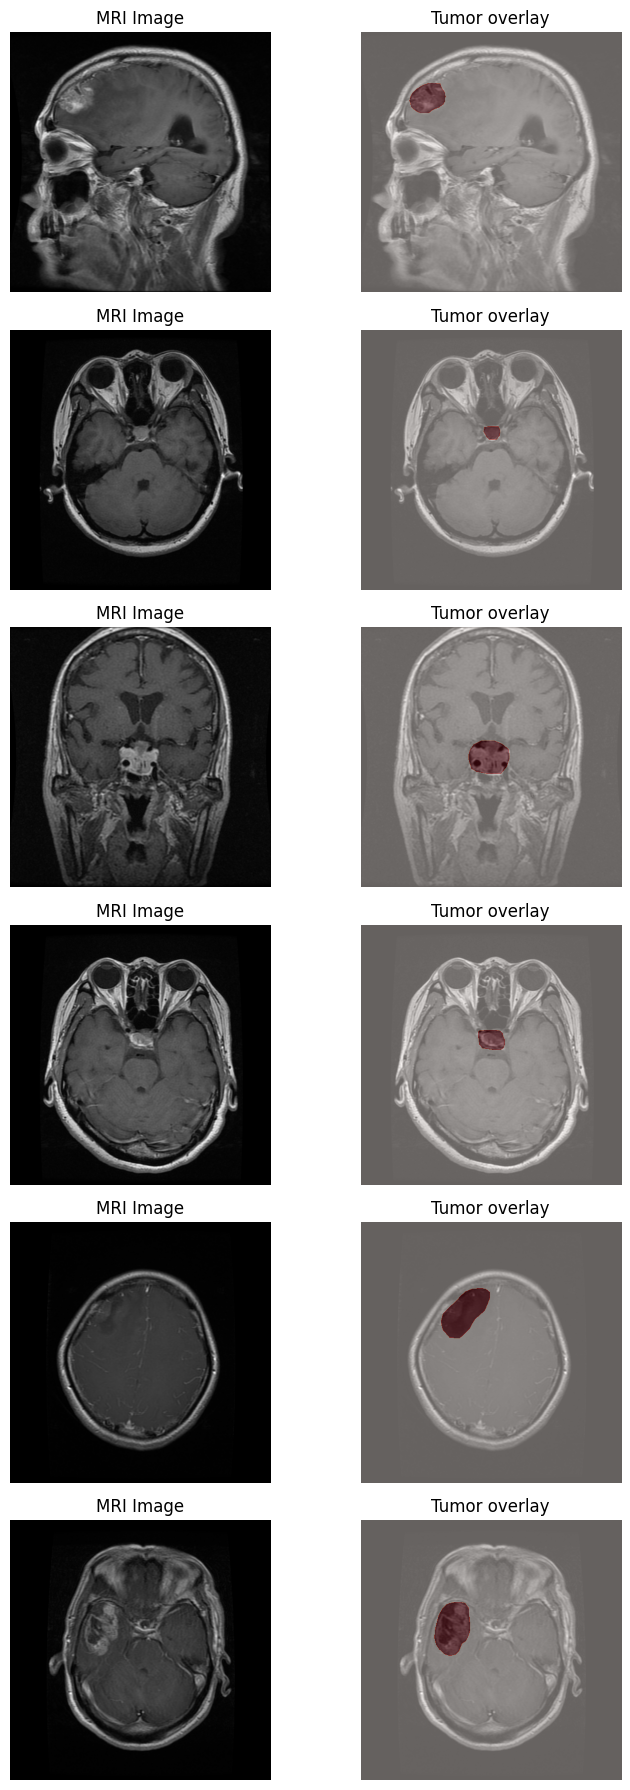

In [7]:
import random

n_samples = 6
fig, axs = plt.subplots(n_samples, 2, figsize=(8, 3*n_samples))

for i in range(n_samples):
    idx = random.randint(0, len(all_images)-1)
    img = np.array(Image.open(all_images[idx]).convert("RGB"))
    mask = np.array(Image.open(all_masks[idx]).convert("L"))
    mask_bin = (mask > 127).astype(np.uint8)

    axs[i,0].imshow(img)
    axs[i,0].set_title("MRI Image")
    axs[i,0].axis("off")

    axs[i,1].imshow(img)
    axs[i,1].imshow(mask_bin, cmap="Reds", alpha=0.4) 
    axs[i,1].set_title("Tumor overlay")
    axs[i,1].axis("off")

plt.tight_layout()
plt.show()

#  **Model, Loss, Optimizer, Metrics**


In [8]:

ENCODER = "resnet34"
ENCODER_WEIGHTS = "imagenet"
ACTIVATION = None  
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=3, 
    classes=1, 
    activation=ACTIVATION
)
model.to(DEVICE)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)              
        preds = preds.view(preds.size(0), -1)     
        targets = targets.view(targets.size(0), -1)
        intersection = (preds * targets).sum(1)
        union = preds.sum(1) + targets.sum(1)
        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

bce = nn.BCEWithLogitsLoss()
dice = DiceLoss()

def loss_fn(preds, targets):
    return 0.5 * bce(preds, targets) + 0.5 * dice(preds, targets)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


import torchmetrics
metric_iou = torchmetrics.JaccardIndex(task="binary").to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 364MB/s]


#  **Training & validation loops**


Epoch 1/12


Train:   0%|          | 0/326 [00:00<?, ?it/s]

Val:   0%|          | 0/58 [00:00<?, ?it/s]

Train loss: 0.3831  Val loss: 0.4168  Val IoU: 0.2798
Epoch 2/12


Train:   0%|          | 0/326 [00:00<?, ?it/s]

Val:   0%|          | 0/58 [00:00<?, ?it/s]

Train loss: 0.2347  Val loss: 0.1993  Val IoU: 0.5575
Epoch 3/12


Train:   0%|          | 0/326 [00:00<?, ?it/s]

Val:   0%|          | 0/58 [00:00<?, ?it/s]

Train loss: 0.2141  Val loss: 0.1931  Val IoU: 0.5751
Epoch 4/12


Train:   0%|          | 0/326 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d63c94c4180>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d63c94c4180>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    self._shutdown_workers()^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^ ^^  ^ 

Val:   0%|          | 0/58 [00:00<?, ?it/s]

Train loss: 0.2027  Val loss: 0.1649  Val IoU: 0.6185
Epoch 5/12


Train:   0%|          | 0/326 [00:00<?, ?it/s]

Val:   0%|          | 0/58 [00:00<?, ?it/s]

Train loss: 0.1913  Val loss: 0.1627  Val IoU: 0.6250
Epoch 6/12


Train:   0%|          | 0/326 [00:00<?, ?it/s]

Val:   0%|          | 0/58 [00:00<?, ?it/s]

Train loss: 0.1831  Val loss: 0.1549  Val IoU: 0.6417
Epoch 7/12


Train:   0%|          | 0/326 [00:00<?, ?it/s]

Val:   0%|          | 0/58 [00:00<?, ?it/s]

Train loss: 0.1727  Val loss: 0.1477  Val IoU: 0.6592
Epoch 8/12


Train:   0%|          | 0/326 [00:00<?, ?it/s]

Val:   0%|          | 0/58 [00:00<?, ?it/s]

Train loss: 0.1811  Val loss: 0.1476  Val IoU: 0.6582
Epoch 9/12


Train:   0%|          | 0/326 [00:00<?, ?it/s]

Val:   0%|          | 0/58 [00:00<?, ?it/s]

Train loss: 0.1731  Val loss: 0.1557  Val IoU: 0.6376
Epoch 10/12


Train:   0%|          | 0/326 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d63c94c4180>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d63c94c4180>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/58 [00:00<?, ?it/s]

Train loss: 0.1642  Val loss: 0.1409  Val IoU: 0.6685
Epoch 11/12


Train:   0%|          | 0/326 [00:00<?, ?it/s]

Val:   0%|          | 0/58 [00:00<?, ?it/s]

Train loss: 0.1660  Val loss: 0.1660  Val IoU: 0.6193
Epoch 12/12


Train:   0%|          | 0/326 [00:00<?, ?it/s]

Val:   0%|          | 0/58 [00:00<?, ?it/s]

Train loss: 0.1599  Val loss: 0.1395  Val IoU: 0.6700


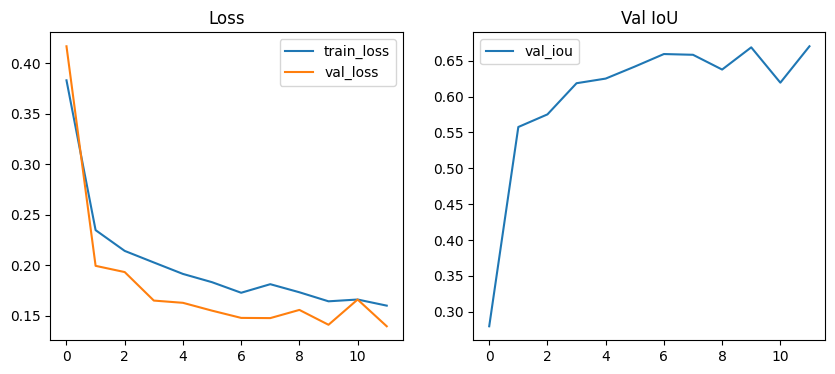

In [9]:
from tqdm.auto import tqdm

def train_one_epoch(loader, model, optimizer):
    model.train()
    running_loss = 0.0
    for imgs, masks in tqdm(loader, desc="Train"):
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)

def valid_one_epoch(loader, model):
    model.eval()
    running_loss = 0.0
    iou_score = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Val"):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            running_loss += loss.item() * imgs.size(0)
            probs = torch.sigmoid(preds)
            preds_bin = (probs > 0.5).int()
            masks_int = masks.int()
            for p, t in zip(preds_bin, masks_int):
                i = metric_iou(p.squeeze(0), t.squeeze(0))
                iou_score += i.item()
    avg_loss = running_loss / len(loader.dataset)
    avg_iou = iou_score / len(loader.dataset)
    return avg_loss, avg_iou

EPOCHS = 12
history = {"train_loss":[], "val_loss":[], "val_iou":[]}

for epoch in range(1, EPOCHS+1):
    print(f"Epoch {epoch}/{EPOCHS}")
    tr_loss = train_one_epoch(train_loader, model, optimizer)
    val_loss, val_iou = valid_one_epoch(val_loader, model)
    scheduler.step(val_loss)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    history["val_iou"].append(val_iou)
    print(f"Train loss: {tr_loss:.4f}  Val loss: {val_loss:.4f}  Val IoU: {val_iou:.4f}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history["val_iou"], label="val_iou")
plt.legend(); plt.title("Val IoU")
plt.show()

# **Visualization utilities**


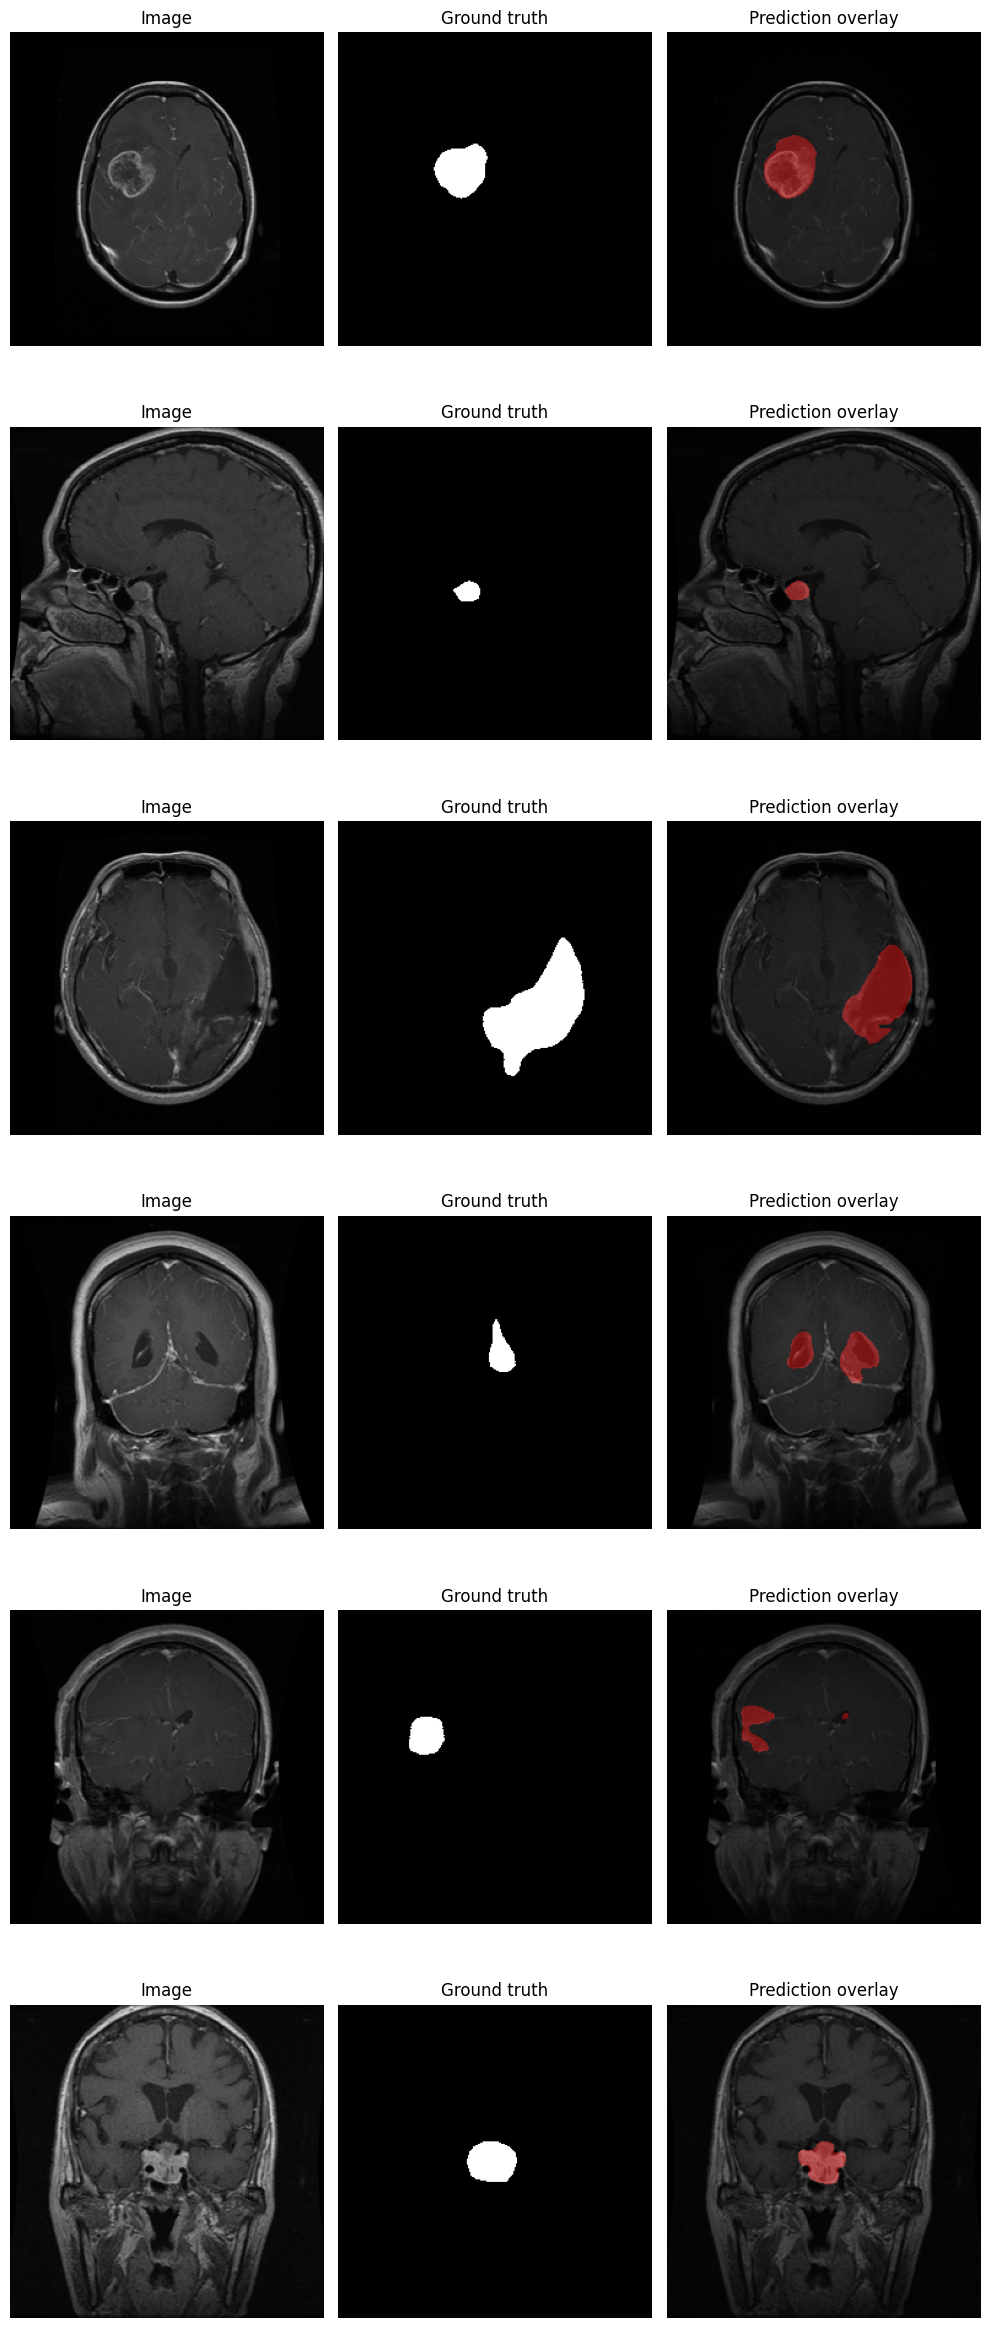

In [10]:
def overlay_mask_on_image(image, mask, alpha=0.4):
    import cv2
    img = image.copy()
    mask_color = np.zeros_like(img)
    mask_color[..., 0] = (mask * 255).astype(np.uint8)  
    overlay = cv2.addWeighted(img, 1-alpha, mask_color, alpha, 0)
    return overlay

model.eval()
n_show = 6
fig, axs = plt.subplots(n_show, 3, figsize=(10, 4*n_show))
for i in range(n_show):
    img_path = val_imgs[i]
    mask_path = val_masks[i]
    img_np = np.array(Image.open(img_path).convert("RGB").resize((256,256)))
    mask_np = np.array(Image.open(mask_path).convert("L").resize((256,256))) > 127
    input_t = valid_transform(image=img_np)["image"].unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred = model(input_t)
        pred_prob = torch.sigmoid(pred).squeeze().cpu().numpy()
        pred_bin = pred_prob > 0.5
    overlay = overlay_mask_on_image(img_np, pred_bin)
    axs[i,0].imshow(img_np); axs[i,0].set_title("Image"); axs[i,0].axis("off")
    axs[i,1].imshow(mask_np, cmap="gray"); axs[i,1].set_title("Ground truth"); axs[i,1].axis("off")
    axs[i,2].imshow(overlay); axs[i,2].set_title("Prediction overlay"); axs[i,2].axis("off")
plt.tight_layout()
plt.show()

#  **Extended Visualizations with heatmaps and contours**


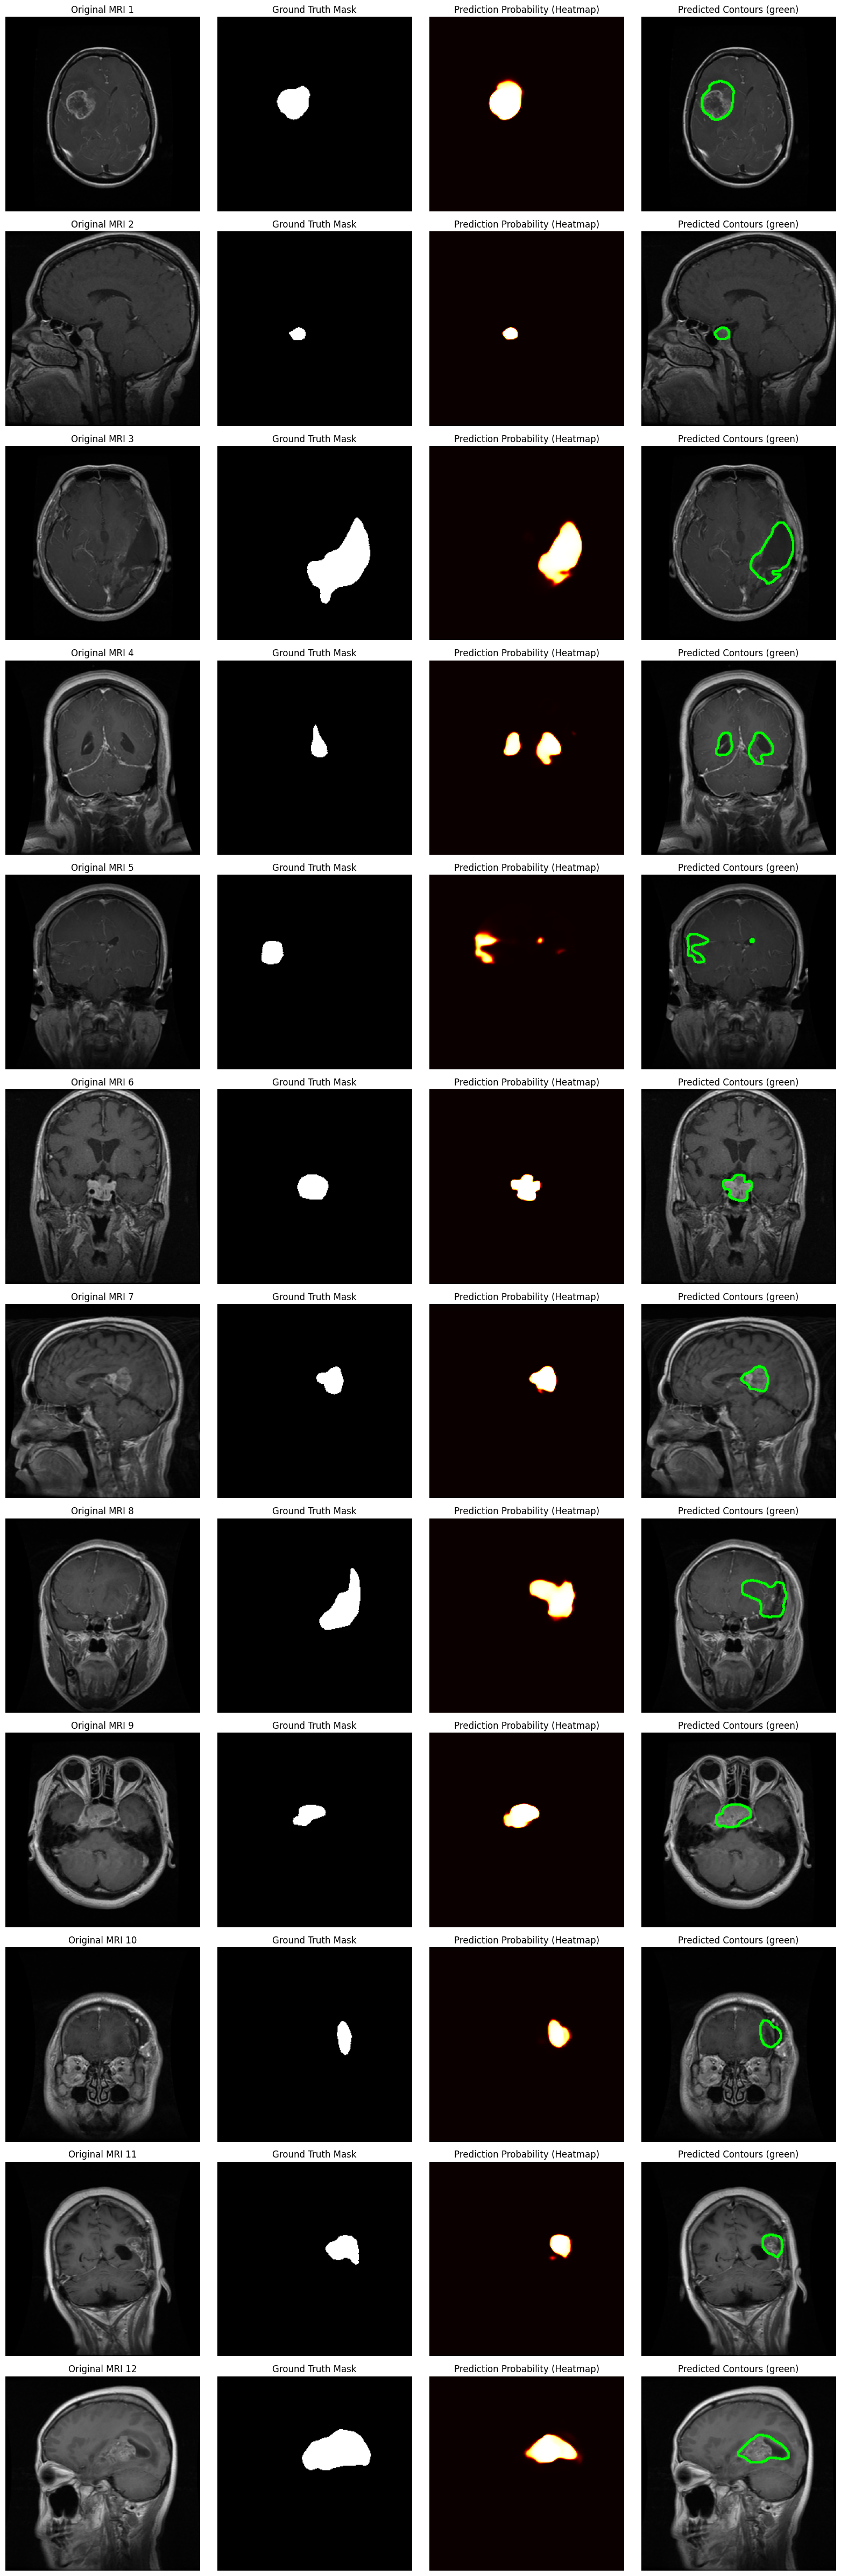

In [11]:
import matplotlib.patches as patches

def visualize_predictions(model, img_paths, mask_paths, n_samples=12):
    model.eval()
    fig, axs = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))

    for i in range(n_samples):
        img_path = img_paths[i]
        mask_path = mask_paths[i]

        img_np = np.array(Image.open(img_path).convert("RGB").resize((256,256)))
        mask_np = np.array(Image.open(mask_path).convert("L").resize((256,256))) > 127

        input_t = valid_transform(image=img_np)["image"].unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            pred = model(input_t)
            pred_prob = torch.sigmoid(pred).squeeze().cpu().numpy()
            pred_bin = pred_prob > 0.5

        overlay_pred = overlay_mask_on_image(img_np, pred_bin)

        contours, _ = cv2.findContours(pred_bin.astype("uint8"), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_img = img_np.copy()
        cv2.drawContours(contour_img, contours, -1, (0,255,0), 2)

        axs[i,0].imshow(img_np)
        axs[i,0].set_title(f"Original MRI {i+1}")
        axs[i,0].axis("off")

        axs[i,1].imshow(mask_np, cmap="gray")
        axs[i,1].set_title("Ground Truth Mask")
        axs[i,1].axis("off")

        axs[i,2].imshow(pred_prob, cmap="hot")
        axs[i,2].set_title("Prediction Probability (Heatmap)")
        axs[i,2].axis("off")

        axs[i,3].imshow(contour_img)
        axs[i,3].set_title("Predicted Contours (green)")
        axs[i,3].axis("off")

    plt.tight_layout()
    plt.show()


visualize_predictions(model, val_imgs, val_masks, n_samples=12)